### 1. Data Loda

In [4]:
import pandas as pd
import numpy as np 

In [6]:
train_data = pd.read_pickle('./raw_data/train.pickle')
test_data = pd.read_pickle('./raw_data/test.pickle')

In [7]:
num_data = train_data.cust_ip_no.value_counts()
ip_list = []
for i in num_data.index:
    ip_list.append(str(i))
    
    
using_ip = []
for i, j in num_data.iteritems():
    if j >= 10079:
        using_ip.append(i)
        

In [9]:
# 총 28개의 ip 실험
print(using_ip)
print(len(using_ip))

[8187.0, 11784.0, 10580.0, 10515.0, 10468.0, 9366.0, 10630.0, 10683.0, 9365.0, 8938.0, 8923.0, 8902.0, 11654.0, 8879.0, 10554.0, 11707.0, 8860.0, 11837.0, 8511.0, 8257.0, 12413.0, 8258.0, 8259.0, 12243.0, 11983.0, 8768.0, 11857.0, 8182.0]
28


In [39]:
# ddos 이력이 있는 ip 8939 추가 
using_ip.extend([8939])
print(using_ip)

[8187.0, 11784.0, 10580.0, 10515.0, 10468.0, 9366.0, 10630.0, 10683.0, 9365.0, 8938.0, 8923.0, 8902.0, 11654.0, 8879.0, 10554.0, 11707.0, 8860.0, 11837.0, 8511.0, 8257.0, 12413.0, 8258.0, 8259.0, 12243.0, 11983.0, 8768.0, 11857.0, 8182.0, 8939]


In [43]:
train_df = train_data[train_data.cust_ip_no.isin(using_ip)]
test_df = test_data[test_data.cust_ip_no.isin(using_ip)] 

In [44]:
print(train_df[train_df.event == 1].cust_ip_no.unique())
print(test_df[test_df.event == 1].cust_ip_no.unique())

[8938. 9365. 8923. 8939. 8879.]
[8938. 8923. 8939.]


In [45]:
train_list = [] 
for i in using_ip:
    df = train_df[train_df.cust_ip_no == i]
    df.reset_index(drop=True, inplace=True) 
    train_list.append(df)
    

test_list = []
for i in using_ip:
    df = test_df[test_df.cust_ip_no == i]
    df.reset_index(drop=True, inplace=True)
    test_list.append(df)    

### 2. Data preprocessing :  create sequence data, remove gap data

In [46]:
from datetime import timedelta, datetime

# train data preprocessing
gap_dic = {}
for ip in range(len(train_list)):
    gap_list = []
    for data in range(len(train_list[ip])-1):
        gap = (datetime.strptime(str(train_list[ip].stamp_inserted[data+1]),'%Y%m%d%H%M%S')) - (datetime.strptime(str(train_list[ip].stamp_inserted[data]),'%Y%m%d%H%M%S'))
        if gap > timedelta(minutes=1):
            gap_list.append((data))
    gap_dic[train_list[ip].cust_ip_no[0]] = gap_list

    
for ip in gap_dic.keys():
    gap_list = []
    for i in gap_dic[ip] :
        gap_num = i - 5
        for j in range(6):
            gap_list.append(gap_num+j)
    gap_dic[ip] = gap_list

    
# test data preprocessing    
gap_dic_test = {}
for ip in range(len(test_list)):
    gap_list = []
    for data in range(len(test_list[ip])-1):
        gap = (datetime.strptime(str(test_list[ip].stamp_inserted[data+1]),'%Y%m%d%H%M%S')) - (datetime.strptime(str(test_list[ip].stamp_inserted[data]),'%Y%m%d%H%M%S'))
        if gap > timedelta(minutes=1):
            gap_list.append((data))
    gap_dic_test[test_list[ip].cust_ip_no[0]] = gap_list

    
for ip in gap_dic_test.keys():
    gap_list = []
    for i in gap_dic_test[ip] :
        gap_num = i -5
        for j in range(6):
            gap_list.append(gap_num+j)
    gap_dic_test[ip] = gap_list


In [47]:
# train: apply log function & diff

from tqdm import tqdm
seq_time = 6
iv = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'icmp_ratio', 'tcp_ratio', 'udp_ratio',
       'tcp_flags_entropy', 'domestic_ratio']
log_trans = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy']

features = len(iv)

normal_X = []
normal_y = [] 

for j in tqdm(range(len(train_list))):
    normal_data = pd.DataFrame(columns=iv)
    normal_label = []
    ip = list(gap_dic.keys())[j]
    gap = gap_dic[ip]
    for i in range(len(train_list[j]) - seq_time):
        if i not in gap:
            input_x = train_list[j].iloc[i:i+seq_time,3:-1]
            input_x[log_trans] = input_x[log_trans]+.1 
            input_x[log_trans] = input_x[log_trans].apply(np.log)
            input_x = input_x.diff().iloc[1:,:]
            label = train_list[j].iloc[i+seq_time-1, -1]
            ip_NO = train_list[j].iloc[i+seq_time-1, 2]
            time = train_list[j].iloc[i+seq_time-1, 0]

            if label == 0:
                normal_data = pd.concat([normal_data, input_x], axis=0)
                ip_label_set = (time, ip_NO, label)            
                normal_label.append(ip_label_set) 

                
    normal_X.append(normal_data) 
    normal_y.append(normal_label)     

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [11:10<00:00, 23.13s/it]


In [48]:
# test: apply log function & diff
from tqdm import tqdm

seq_time = 6
iv = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'icmp_ratio', 'tcp_ratio', 'udp_ratio',
       'tcp_flags_entropy', 'domestic_ratio']
log_trans = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'tcp_flags_entropy', 'domestic_ratio']

features = len(iv)

X_ts = []
y_ts = [] 


for j in tqdm(range(len(test_list))):
    ts_data = pd.DataFrame(columns=iv)
    ts_label = []
    ip = list(gap_dic_test.keys())[j]
    gap = gap_dic_test[ip]
    
    
    for i in range(len(test_list[j]) - seq_time):
        if i not in gap:
            input_x = test_list[j].iloc[i:i+seq_time,3:-1]
            input_x[log_trans] = input_x[log_trans]+.1 
            input_x[log_trans] = input_x[log_trans].apply(np.log)
            input_x = input_x.diff().iloc[1:,:] 
            label = test_list[j].iloc[i+seq_time-1, -1]
            ip_NO = test_list[j].iloc[i+seq_time-1, 2]  
            time = test_list[j].iloc[i+seq_time-1, 0]
            
            ts_data = pd.concat([ts_data, input_x], axis=0)
            ip_label_set = (time, ip_NO, label)            
            ts_label.append(ip_label_set)         
        else: 
            pass
            
    X_ts.append(ts_data) 
    y_ts.append(ts_label) 
    

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [11:52<00:00, 24.57s/it]


In [49]:
# train: data scaling 
from sklearn import preprocessing

X_normal = pd.DataFrame(columns=iv)
for i in normal_X:
    i = i.fillna(0)
    tmp_input = pd.DataFrame(preprocessing.scale(i.values), columns=iv)
    X_normal = pd.concat([X_normal, tmp_input], axis=0)

y_normal = []
for i in normal_y:
    y_normal.extend(i)


In [50]:
# test: data scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

X_ts_ = pd.DataFrame(columns=iv)
for i in X_ts:
    i = i.fillna(0)
    tmp_input = pd.DataFrame(preprocessing.scale(i.values), columns=iv)
    X_ts_ = pd.concat([X_ts_, tmp_input], axis=0)

y_ts_ = []
for i in y_ts:
    y_ts_.extend(i)


In [51]:
# data check
X_normal = X_normal.values.reshape(-1, 5, 12) 
train_y_df = pd.DataFrame(y_normal, columns=['time','ip','label'])
train_y_df.head()

,time,ip,label
0,20200801000500,8187.0,0.0
1,20200801000600,8187.0,0.0
2,20200801000700,8187.0,0.0
3,20200801000800,8187.0,0.0
4,20200801000900,8187.0,0.0


In [52]:
# test df
X_ts = X_ts_.values.reshape(-1, 5, 12) 
y_ts = pd.DataFrame(y_ts_, columns=['time','ip','label'])

### 3. CNN AE

In [139]:
from tensorflow.keras import Model, models, optimizers, utils, layers
from keras.layers import LSTM, Dense, Activation, Conv1D, Dropout, Conv1DTranspose, BatchNormalization, RepeatVector
from keras.models import load_model
import keras.backend as K

adam = optimizers.Adam(lr=1e-5)
kernel_s = 3 
seq_time = 5


x = layers.Input(shape=(seq_time, features))
K.clear_session()
enc = models.Sequential([x,
    layers.Conv1D(filters=12, kernel_size=kernel_s, padding='same', strides=1),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.Conv1D(filters=48, kernel_size=kernel_s,  padding='same', strides=1),
    layers.BatchNormalization(), 
    Activation('relu'),
    layers.Conv1D(filters=12, kernel_size=kernel_s, padding='same', strides=1)])

z = enc(x)

dec =  models.Sequential([
    layers.Conv1DTranspose(filters=12, kernel_size=kernel_s, padding='same', strides=1),
   # layers.BatchNormalization(),
    Activation('relu'),
    layers.Conv1DTranspose(filters=48, kernel_size=kernel_s, padding='same', strides=1),
    #layers.BatchNormalization(),
    Activation('relu'),
    layers.Conv1DTranspose(filters=12, kernel_size=kernel_s, padding='same'),
]) 

x_hat = dec(z) 

cnn_ae = Model(x, x_hat) 
cnn_ae.compile(optimizer=adam, loss='mse') 


In [140]:
#25
hist = cnn_ae.fit(X_normal, X_normal, epochs=30, validation_split=0.1, batch_size=64, shuffle=True, verbose=2)

Epoch 1/30
4104/4104 - 8s - loss: 0.8930 - val_loss: 0.7533
Epoch 2/30
4104/4104 - 6s - loss: 0.6749 - val_loss: 0.6528
Epoch 3/30
4104/4104 - 6s - loss: 0.5959 - val_loss: 0.5800
Epoch 4/30
4104/4104 - 6s - loss: 0.5342 - val_loss: 0.5226
Epoch 5/30
4104/4104 - 6s - loss: 0.4886 - val_loss: 0.4823
Epoch 6/30
4104/4104 - 6s - loss: 0.4535 - val_loss: 0.4523
Epoch 7/30
4104/4104 - 6s - loss: 0.4267 - val_loss: 0.4279
Epoch 8/30
4104/4104 - 6s - loss: 0.4035 - val_loss: 0.4070
Epoch 9/30
4104/4104 - 6s - loss: 0.3834 - val_loss: 0.3888
Epoch 10/30
4104/4104 - 6s - loss: 0.3658 - val_loss: 0.3726
Epoch 11/30
4104/4104 - 6s - loss: 0.3500 - val_loss: 0.3591
Epoch 12/30
4104/4104 - 6s - loss: 0.3368 - val_loss: 0.3453
Epoch 13/30
4104/4104 - 6s - loss: 0.3240 - val_loss: 0.3335
Epoch 14/30
4104/4104 - 6s - loss: 0.3130 - val_loss: 0.3235
Epoch 15/30
4104/4104 - 6s - loss: 0.3034 - val_loss: 0.3143
Epoch 16/30
4104/4104 - 6s - loss: 0.2950 - val_loss: 0.3065
Epoch 17/30
4104/4104 - 6s - loss

In [147]:
# from plotly.offline import plot, iplot 
# import plotly.graph_objects as go

# loss = hist.history['loss'] 
# val_loss = hist.history['val_loss'] 

# fig = go.Figure()
# fig.add_trace(go.Scatter(y=loss, mode='lines', name='loss')) 
# fig.add_trace(go.Scatter(y=val_loss, mode='lines', name='val_loss'))
# fig.update_layout(height=400, width=600, title='loss of CAE')
# fig.show() 

In [142]:
# try detecting with train set and setting the optimal threshold

pred_x = cnn_ae.predict(X_normal).reshape(X_normal.shape[0],-1)
real = X_normal.reshape(X_normal.shape[0], -1) 
log_mse = np.log(np.mean(np.power(real-pred_x, 2), axis=1)) 
mse = np.mean(np.power(real-pred_x, 2), axis=1)
train_df_error = pd.DataFrame({'time':train_y_df.time, 'recon_size':mse, 'IP':train_y_df.ip, 'reconstruction_error':log_mse, 'Label':train_y_df.label})


thr = train_df_error[['reconstruction_error','Label']].describe()
error = sorted(train_df_error.reconstruction_error.values, reverse=True)

up_to_99_5 = int(round(len(error) * 0.005,0)) 
up_to_99_5

threshold = error[up_to_99_5]
max_error = error[0]
print(thr)
print(threshold) 

       reconstruction_error     Label
count         291779.000000  291779.0
mean              -2.320022       0.0
std                1.026889       0.0
min               -5.691159       0.0
25%               -2.956111       0.0
50%               -2.307990       0.0
75%               -1.676189       0.0
max                5.665243       0.0
0.7717926650735368


In [143]:
# Model evaluation (batch 64, epoch 50) with upper 0.5%
from sklearn.metrics import confusion_matrix, classification_report

pred_x = cnn_ae.predict(X_ts).reshape(X_ts.shape[0],-1)
real = X_ts.reshape(X_ts.shape[0], -1)
log_mse = np.log(np.mean(np.power(real-pred_x, 2), axis=1))
mse = np.mean(np.power(real-pred_x, 2), axis=1)
test_df_error = pd.DataFrame({'time':y_ts.time, 'reconstruction_error':log_mse, 'recon_size':mse, 'Label':y_ts.label, 'IP':y_ts.ip})



pred_y = [1 if e > threshold else 0 for e in test_df_error['reconstruction_error'].values]
confusion_m = confusion_matrix(y_ts.label, pred_y)
classification = classification_report(y_ts.label, pred_y)
test_df_error['predicted_y'] = pred_y
print(confusion_m)
print(classification)


[[289164   1767]
 [     1     77]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    290931
         1.0       0.04      0.99      0.08        78

    accuracy                           0.99    291009
   macro avg       0.52      0.99      0.54    291009
weighted avg       1.00      0.99      1.00    291009



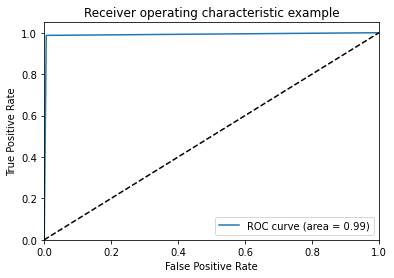

In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

fpr, tpr, thresholds = roc_curve(test_df_error.Label, pred_y)
roc_auc = auc(fpr, tpr)

plt.figure() 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right") 
plt.show()

In [146]:
# # comparing the reconstruction distribution 
# import plotly.figure_factory as ff
# from plotly.offline import plot, iplot 

# test_ddos = test_df_error[test_df_error.Label ==1 ]
# test_normal = test_df_error[test_df_error.Label ==0 ]
# data = [train_df_error.reconstruction_error, test_ddos.reconstruction_error, test_normal.reconstruction_error]
# group = ['train normal', 'test ddos', 'test normal'] 
# fig = ff.create_distplot(data, group, bin_size=[.2,.2,.2])
# fig.update_layout(title='Reconstruction distribution') 
# fig.show() 